In [30]:
import os
import json
import numpy as np
import torch
import collections
from Bio import SeqIO
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import re
from torch.nn import CrossEntropyLoss
import esm

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)

# Load model and tokenizer (Avoid loading entire model)
#model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
alphabet = esm.data.Alphabet.from_architecture("ESM-1b")

celoss = CrossEntropyLoss()
batch_converter = alphabet.get_batch_converter()

T5_vocab = [ i[1] for i in tokenizer.get_vocab().keys() if i.startswith("▁") and not re.search(r"[UZOBX]", i)] # this is not a regular underscore char
T5_vocab_ix = [ j for j,i in enumerate(tokenizer.get_vocab().keys()) if i.startswith("▁") and not re.search(r"[UZOBX]", i)]
print(len(T5_vocab), len(T5_vocab_ix))
print(T5_vocab, T5_vocab_ix)

ESM2_vocab = [i for i in alphabet.all_toks if len(i) == 1 and not re.search(r"[UZOBX\.-]", i)]
ESM2_vocab_ix = [j for j,i in enumerate(alphabet.all_toks) if len(i) == 1 and not re.search(r"[UZOBX\.-]", i)]
print(len(ESM2_vocab))
print(ESM2_vocab,  ESM2_vocab_ix)


def get_single_aa_losses(datadict, prot_tokens):
    all_loss_sequences = []
    logits = datadict['aamask_1']['logits']
    for i in range(len(prot_tokens)):
        aaloss_sequence = []
        if datadict['aamask_1']['loss'][i] < 0:
            aaloss_sequence.append(-1)
        else:
            for j in range(len(prot_tokens)):
                loss = celoss(torch.tensor(logits[i][j]).double(), torch.tensor(prot_tokens[j]))   
                aaloss_sequence.append(loss.item())
        all_loss_sequences.append(aaloss_sequence)
    return all_loss_sequences

def get_single_aa_losses_indiv(logits, prot_tokens):
    aaloss_sequence = []
    for j in range(len(prot_tokens)):
        loss = celoss(torch.tensor(logits[j]).double(), torch.tensor(prot_tokens[j]))   
        aaloss_sequence.append(loss.item())
    return aaloss_sequence

def get_position_colors(unip, diso_seq):
    aa_colors = []
    for e in diso_seq:
        if e == "-":
            aa_colors.append('b')
        else:
            aa_colors.append('r')
    return aa_colors

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("../disprot_OK_fullset.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("../disprot_OK_fullset_annotations.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(datadict.keys())} proteins")

t5dir_disprot = "../loss_T5_disprot"
esm2dir = "../loss_ESM2_disprot"


20 20
['A', 'L', 'G', 'V', 'S', 'R', 'E', 'D', 'T', 'I', 'P', 'K', 'F', 'Q', 'N', 'Y', 'M', 'H', 'W', 'C'] [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
20
['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C'] [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Loaded 2145 proteins


In [38]:
os.listdir(t5dir_disprot)

['O00522.json',
 'P08253.json',
 'Q13043.json',
 'Q658P3.json',
 'P02655.json',
 'P03087.json',
 'Q99075.json',
 'Q5UPT2.json',
 'P03259.json',
 'G5EFZ1.json',
 'E6PBU3.json',
 'Q8IVH8.json',
 'P0A9A6.json',
 'B0FRH7.json',
 'P19793.json',
 'I7MK25.json',
 'E6Y5X0.json',
 'O23764.json',
 'D2JX42.json',
 'Q9QUG2.json',
 'P10761.json',
 'P03407.json',
 'P63165.json',
 'Q87P35.json',
 'Q56WD9.json',
 'Q62165.json',
 'Q9Q8E9.json',
 'Q9ERE3.json',
 'P78560.json',
 'Q9JLC3.json',
 'P34233.json',
 'F6IAY2.json',
 'Q04049.json',
 'O95149.json',
 'A5F384.json',
 'P53816.json',
 'Q0PF16.json',
 'P48439.json',
 'P06748.json',
 'P15311.json',
 'P62965.json',
 'P03265.json',
 'Q96RF0.json',
 'Q5QGG3.json',
 'S6AWC2.json',
 'P40855.json',
 'P0A8N3.json',
 'O25010.json',
 'Q60795.json',
 'P22531.json',
 'Q4JC68.json',
 'Q8BHZ5.json',
 'P98066.json',
 'P35680.json',
 'Q9GZN7.json',
 'P0A882.json',
 'Q83AR4.json',
 'P26368.json',
 'P04156.json',
 'P10175.json',
 'O43172.json',
 'O43236.json',
 'P0A6X3

In [50]:

# for filename in os.listdir(t5dir_disprot)[:1]:
for filename in ["P04637.json"]:
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        with open(os.path.join(t5dir_disprot, filename)) as f:
            data = json.load(f)
            t5_dict = data[uniprot_id]

            L = len(datadict[uniprot_id]['seq'])
            this_seq = datadict[uniprot_id]['seq']

            aa_colors = get_position_colors(uniprot_id, datadict[uniprot_id]['disorder'])
            
            print(uniprot_id, L)
            ## Tokenize
            input_seq = " ".join(list(re.sub(r"[UZOB]", "X", this_seq)))
            T5_prot_toks = tokenizer(input_seq)['input_ids'][:-1] ## remove end of sequence token
            
            ## Get aa-level losses
            T5_aaloss_sequences   = get_single_aa_losses(t5_dict, T5_prot_toks)
            

            ## get unmasked aa-level losses for the entire sequence
            if os.path.exists(os.path.join(esm2dir, "logits", uniprot_id + "_logits.pt")):
                t5_dict['unmasked_logits'] = torch.load(os.path.join(t5dir_disprot, "logits", uniprot_id + "_logits.pt"))
                T5_unmasked_aaloss_sequence   = get_single_aa_losses_indiv(t5_dict['unmasked_logits'].squeeze(), T5_prot_toks)
            else:
                raise ValueError(f"Missing unmasked logits for {uniprot_id}")
            
            ## save T5_aaloss_sequences to a file
            os.makedirs(os.path.join(t5dir_disprot, "losses"), exist_ok=True)
            with open(os.path.join(t5dir_disprot, "losses", uniprot_id + "_losses.json"), "w") as f:
                json.dump(T5_aaloss_sequences, f)

            ## save T5_unmasked_aaloss_sequence to a file
            with open(os.path.join(t5dir_disprot, "losses", uniprot_id + "_unmasked_losses.json"), "w") as f:
                json.dump(T5_unmasked_aaloss_sequence, f)

            

            if os.path.exists(os.path.join(esm2dir, uniprot_id + ".json")) and os.path.exists(os.path.join(esm2dir, "logits", uniprot_id + "_logits.pt")):
                esm2_dict = json.load(open(os.path.join(esm2dir, uniprot_id + ".json")))[uniprot_id]
                batch_labels, batch_strs, batch_tokens = batch_converter([(uniprot_id, input_seq)])
                ESM2_prot_toks = batch_tokens.squeeze()[1:-1].numpy().tolist() ## remove start and end of sequence token
                ESM2_aaloss_sequences = get_single_aa_losses(esm2_dict, ESM2_prot_toks)
                esm2_dict['unmasked_logits'] = torch.load(os.path.join(esm2dir, "logits", uniprot_id + "_logits.pt"))
                ESM2_unmasked_aaloss_sequence = get_single_aa_losses_indiv(esm2_dict['unmasked_logits'].squeeze(), ESM2_prot_toks)

                ## save ESM2_aaloss_sequences to a file
                os.makedirs(os.path.join(esm2dir, "losses"), exist_ok=True)
                with open(os.path.join(esm2dir, "losses", uniprot_id + "_losses.json"), "w") as f:
                    json.dump(ESM2_aaloss_sequences, f)

                ## save ESM2_unmasked_aaloss_sequence to a file
                with open(os.path.join(esm2dir, "losses", uniprot_id + "_unmasked_losses.json"), "w") as f:
                    json.dump(ESM2_unmasked_aaloss_sequence, f)


P04637 393


/tmp/ipykernel_1735694/2258694713.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = celoss(torch.tensor(logits[j]).double(), torch.tensor(prot_tokens[j]))


(393, 393)

In [41]:
esm2_dict.keys()

dict_keys(['aamask_1', 'unmasked_logits'])

In [42]:
print(np.arange(L).shape)
print(np.array(T5_aaloss_sequences).shape)

(393,)
(393, 393)


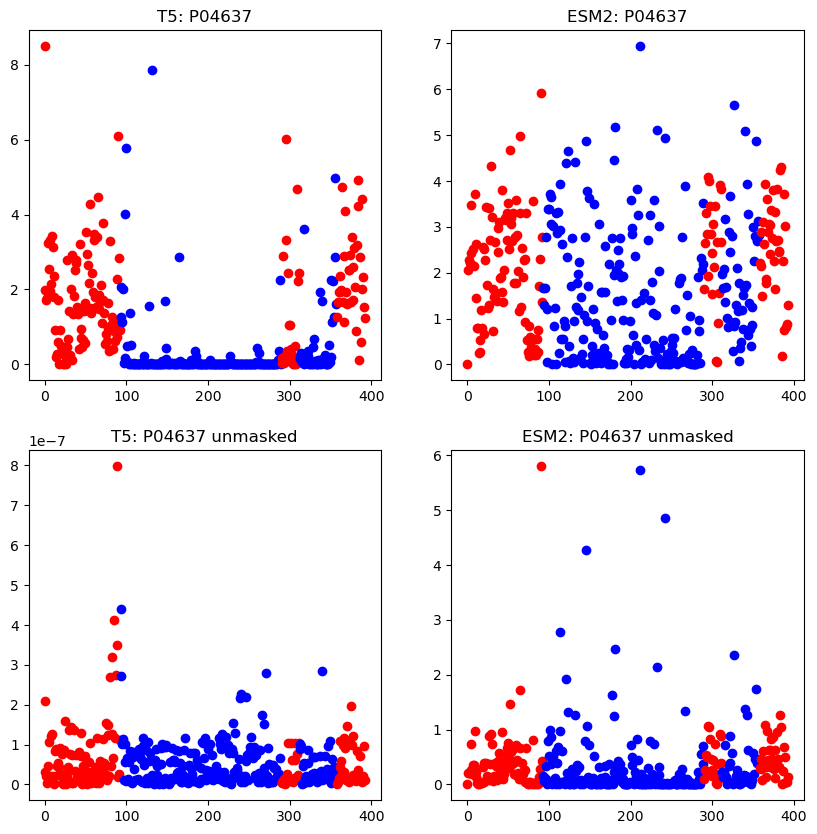

In [43]:
# plot the aa-level losses
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

for i in range(L):
    ax1.scatter( i , T5_aaloss_sequences[i][i], c=aa_colors[i])
    ax1.set_title(f"T5: {uniprot_id}")
    ax2.scatter( i , ESM2_aaloss_sequences[i][i], c=aa_colors[i])
    ax2.set_title(f"ESM2: {uniprot_id}")
    ax3.scatter( i , T5_unmasked_aaloss_sequence[i], c=aa_colors[i])
    ax3.set_title(f"T5: {uniprot_id} unmasked")
    ax4.scatter( i , ESM2_unmasked_aaloss_sequence[i], c=aa_colors[i])
    ax4.set_title(f"ESM2: {uniprot_id} unmasked")
plt.show()



In [37]:
print(len(datadict[uniprot_id]['disorder']))
print(len(datadict[uniprot_id]['seq']))
print(uniprot_id)

736
736
O00522
